In [89]:
import os
import sys
import random
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

sys.path.append('../src')

from design_gene_blocks import DesignEblocks
from design_IVA_primers import DesignPrimers
from snapgene_output import SnapGeneOutput
from utils import natural_amino_acids, read_plasmid

# !pip3 install openpyxl

# For plasmid viewing
import biotite.sequence as seq
import biotite.sequence.io.genbank as gb
import biotite.sequence.graphics as graphics
import biotite.database.entrez as entrez

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
# TODO TRY RUNNING TESTS FROM COMMAND LINE AS WELL AND SEE IF THIS WORKS

In this tutorial we will randomly design a number of mutations for the replicative DNA polymerase DnaE1 from *Mycobacterium smegmatis* to better understand it's function. <br>

The expression plasmid containing Msmeg DnaE1 is XXX and is stored in XXX. <br>

Gene from mycobrowser XXX and is stored in XXX <br>

In [91]:
# File locations for input and output

vector = 'files/snapgene_vector.dna' # TODO Change name and change vector (see snapgene computer which one to take)
msmeg_dnae1 = 'files/A0QX55.fasta'  # M. smegmatis DnaE1 gene
gene_name = "Msmeg_DnaE1"
output_location = 'output/'  # Location to store the files created in this notebook
codon_usage = 'Mycobacterium Smegmatis' # We want to use the codon usage of this organism
codon_usage_fp = r"C:\Users\Rosan\Documents\git\my_repositories\design_gene_blocks\src\data\codon_usage" # Location of the codon usage files
optimize = 'cost'

In [92]:
# process vector

test = SnapGeneOutput.read_snapgene_dna_file(vector)

# TODO Figure out how to ad ID and name to the plasmid
# TODO Read features and parse automatically
# TODO Add primers as well in snapgene output

print(len(test.seq))

7871


In [93]:
print(test)

ID: 0000
Name: pINIT-DnaE1
Description: pINIT-DnaE1 vector for tutorial
Number of features: 8
/molecule_type=DNA
/topology=circular
/data_file_division=UNC
/date=2023-12-04 00:00:00
Seq('tggccgctcttctAGTagcggttcatctgcggggtcctccttcgtgcacctgca...ggt')


In [169]:
for i in test.features:
    # print(i)
    if not (i.type == "terminator") and not (i.type == "rep_origin") and not (i.type == "CDS"):
        print(i.type)
        print(i.location, i.location.start, i.location.end)
        print(i.qualifiers)
        for j in i.qualifiers:
            print(j)
        print('---------')

promoter
[5795:6241](+) 5795 6241
{'gene': ['sacR'], 'note': ['sacB promoter and control region'], 'label': ['sacB promoter']}
gene
note
label
---------
promoter
[3900:4003](+) 3900 4003
{'note': ['promoter of the E. coli cat gene encoding chloramphenicol acetyltransferase'], 'label': ['cat promoter']}
note
label
---------
misc_feature
[21:3536](+) 21 3536
{'label': ['DnaE1']}
label
---------


In [172]:
# TODO Certain colors for certain features
# TODO first check if there is a label other wise use no label or unknown
# TODO Do the same for gb files

features_test = []
for i in test.features:
    qualifiers = list(i.qualifiers.keys())
    print(qualifiers)
    print(i.type)
    if i.type == "terminator":
        features_test.append(Feature("terminator", [Location(int(i.location.start), int(i.location.end))], qual={"label" : ' '.join(i.qualifiers['label'])}))
    elif i.type == "CDS":
        features_test.append(Feature("CDS", [Location(int(i.location.start), int(i.location.end))], qual={"label" : "test1"}))
    elif i.type == "rep_origin":
        features_test.append(Feature("rep_origin", [Location(int(i.location.start), int(i.location.end))], qual={"label" : ' '.join(i.qualifiers['label'])}))
    elif i.type == "promotor":
        features_test.append(Feature("promotor", [Location(int(i.location.start), int(i.location.end))], qual={"label" : ' '.join(i.qualifiers['label'])}))
    elif i.type == "misc_feature":
        features_test.append(Feature("misc_feature", [Location(int(i.location.start), int(i.location.end))], qual={"label" : ' '.join(i.qualifiers['label'])}))
    # features.append(Feature(i.type, [Location(i.location.start, i.location.end)], qual={"gene" : i.qualifiers['gene']}))



features_test

['note', 'label']
terminator
['gene', 'note', 'label']
terminator
['direction', 'note', 'label']
rep_origin
['parts', 'codon_start', 'gene', 'note', 'product', 'protein_id', 'transl_table', 'translation', 'label']
CDS
['gene', 'note', 'label']
promoter
['codon_start', 'gene', 'note', 'product', 'transl_table', 'translation', 'label']
CDS
['note', 'label']
promoter
['label']
misc_feature


[Feature("terminator", [Location(3675, 3703, strand=Location.Strand.FORWARD, defect=Location.Defect.NONE)], qual={'label': 'rrnB T2 terminator'}),
 Feature("terminator", [Location(7736, 7823, strand=Location.Strand.FORWARD, defect=Location.Defect.NONE)], qual={'label': 'rrnB T1 terminator'}),
 Feature("rep_origin", [Location(5008, 5597, strand=Location.Strand.FORWARD, defect=Location.Defect.NONE)], qual={'label': 'ori'}),
 Feature("CDS", [Location(6241, 7663, strand=Location.Strand.FORWARD, defect=Location.Defect.NONE)], qual={'gene': 'test1'}),
 Feature("CDS", [Location(4003, 4663, strand=Location.Strand.FORWARD, defect=Location.Defect.NONE)], qual={'gene': 'test1'}),
 Feature("misc_feature", [Location(21, 3536, strand=Location.Strand.FORWARD, defect=Location.Defect.NONE)], qual={'label': 'DnaE1'})]

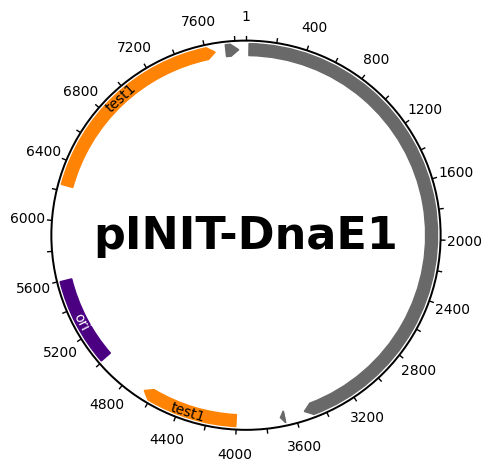

In [173]:
annotation = Annotation(features_test)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection="polar")
graphics.plot_plasmid_map(
    ax, 
    annotation, 
    plasmid_size=len(test.seq), 
    label=f"{test.name}",
    label_properties={"fontsize": 10})

ticks = ax.get_xticks()
labels = ax.get_xticklabels()

# Oly show a few ticks

ax.set_xticks(ticks[::2])

fig.tight_layout()

plt.show()

terminator
[3675:3703](+) 3675 3703
{'note': ['transcription terminator T2 from the E. coli rrnB gene'], 'label': ['rrnB T2 terminator']}
note
label
---------
terminator
[7736:7823](+) 7736 7823
{'gene': ['Escherichia coli rrnB'], 'note': ['transcription terminator T1 from the E. coli rrnB gene'], 'label': ['rrnB T1 terminator']}
gene
note
label
---------
rep_origin
[5008:5597](+) 5008 5597
{'direction': ['RIGHT'], 'note': ['high-copy-number ColE1/pMB1/pBR322/pUC origin of replication'], 'label': ['ori']}
direction
note
label
---------
CDS
join{[6241:6328](+), [6328:7663](+)} 6241 7663
{'parts': ['1:signal peptide'], 'codon_start': [1], 'gene': ['Bacillus subtilis sacB'], 'note': ['negative selection marker'], 'product': ['secreted levansucrase that renders bacterial growth sensitive to sucrose'], 'protein_id': [''], 'transl_table': [1], 'translation': ['MNIKKFAKQATVLTFTTALLAGGATQAFA,KETNQKPYKETYGISHITRHDMLQIPEQQKNEKYKVPEFDSSTIKNISSAKGLDVWDSWPLQNTDGTVANYHGYHIVFALAGDPKNADDTSIYMFYQKVGETS

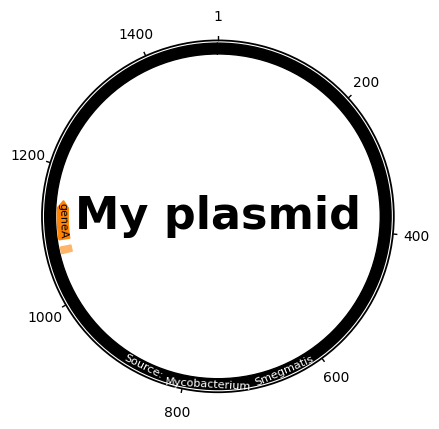

In [96]:
# TODO Add image of the vector

# https://www.biotite-python.org/examples/gallery/sequence/plasmid_map_custom.html

fig, ax = read_plasmid(dna_fp=vector,
                       organism=codon_usage,
                       gene_name=gene_name)

# Resize figure
fig.set_figheight(4)
fig.set_figwidth(4)

plt.show()

In [69]:
print(len(test.seq))

7871


test1 -10-30 >
test2 20-50 >


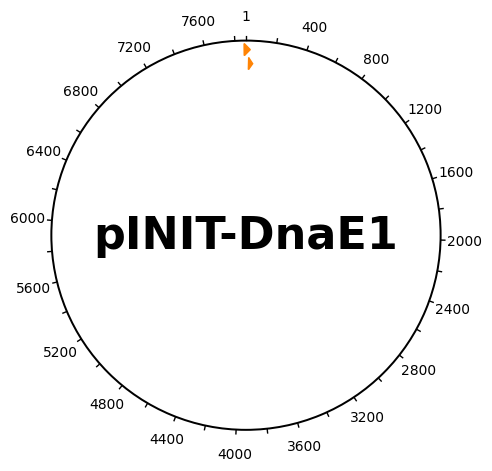

In [113]:
figsize = (5.0, 5.0)

feature1 = Feature("CDS", [Location(-10, 30 )], qual={"gene" : "test1"})
feature2 = Feature("CDS", [Location(20,  50 )], qual={"gene" : "test2"})
annotation = Annotation([feature1, feature2])

for f in sorted(list(annotation)):
    print(f.qual["gene"], "".join([str(loc) for loc in f.locs]))

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection="polar")
graphics.plot_plasmid_map(
    ax, 
    annotation, 
    plasmid_size=len(test.seq), 
    label=f"{test.name}",
    label_properties={"fontsize": 4})

ticks = ax.get_xticks()
labels = ax.get_xticklabels()

# Oly show a few ticks

ax.set_xticks(ticks[::2])

fig.tight_layout()

plt.show()

In [88]:
organism = "Smegmatis"
name = test.name

annotation = seq.Annotation()


for feature_info in test.features:
    feature_location = Location(feature_info["start"], feature_info["end"])
    print(feature_location)
    feature = Feature(
        key=feature_info["key"],
        locs=feature_location,
        # qualifiers=feature_info["qualifiers"],
    )
    annotation.add_feature(feature)

# # Add the different features to the vector

# # Ori
# seq.Feature(
#     "rep_origin",
#     [seq.Location(600, 700, seq.Location.Strand.REVERSE)],
#     {"regulatory_class": "promoter", "note": "MyProm"}
# ),

# # Promoter
# seq.Feature(
#     "regulatory",
#     [seq.Location(1000, 1060)],
#     {"regulatory_class": "promoter", "note": "MyProm"}
# ),
# seq.Feature(
#     "protein_bind",
#     [seq.Location(1025, 1045)],
#     {"note": "repr"}
# ),

#     # Gene A
#     seq.Feature(
#         "regulatory",
#         [seq.Location(1070, 1080)],
#         {"regulatory_class": "ribosome_binding_site"}
#     ),
#     seq.Feature(
#         "CDS",
#         [seq.Location(1091, 1150)],
#         {"product": "geneA"}
#     ),


# # Terminator
# seq.Feature(
#     "regulatory",
#     [seq.Location(310, 350)],
#     {"regulatory_class": "terminator", "note": "MyTerm"}
# ),

# # Primers
# # The labels will be too long to be displayed on the map
# # If you want to display them nevertheless, set the
# # 'omit_oversized_labels' to False
# seq.Feature(
#     "primer_bind",
#     [seq.Location(1385, 1405)],
#     {"note": "geneC"}
# ),
# seq.Feature(
#     "primer_bind",
#     [seq.Location(345, 365, seq.Location.Strand.REVERSE)],
#     {"note": "geneC_R"}
# ),

# # Terminator
# seq.Feature(
#     "regulatory",
#     [seq.Location(310, 350)],
#     {"regulatory_class": "terminator", "note": "MyTerm"}
# ),
# ])

# fig = plt.figure(figsize=(4.0, 4.0))
# ax = fig.add_subplot(111, projection="polar")
# graphics.plot_plasmid_map(
#     ax, 
#     annotation, 
#     plasmid_size=len(test.seq), 
#     label=f"{name}",
#     label_properties={"fontsize": 2})

# ticks = ax.get_xticks()
# labels = ax.get_xticklabels()

# fig.tight_layout()

First we open the nucleotide sequence of Msmeg DnaE1 and translate this to the protein sequence. Here, the start and stop codon are not translated 

In [5]:
# Load the nucleotide sequence

msmeg_dnae1_dna = DesignEblocks.read_single_seq(msmeg_dnae1)
print("Nucleotide sequence: ", type(msmeg_dnae1_dna), msmeg_dnae1_dna)

# Translate nucleotide to protein sequence

msmeg_dnae1_protein = msmeg_dnae1_dna.translate()
print("Protein sequence: ", msmeg_dnae1_protein)

# Create a list of all DnaE1 residues

msmeg_dnae1_residues = [i + str(j) for i, j in zip(msmeg_dnae1_protein, range(1, len(msmeg_dnae1_protein) + 1))]
print("Residues: ", msmeg_dnae1_residues)

Nucleotide sequence:  <class 'Bio.Seq.Seq'> atgagcggttcatctgcggggtcctccttcgtgcacctgcacaaccacaccgagtattcgatgctggacggtgccgcgaagatcacgcccatgctcgccgaggtggagcggctggggatgcccgcggtggggatgaccgaccacggaaacatgttcggtgccagcgagttctacaactccgcgaccaaggccgggatcaagccgatcatcggcgtggaggcatacatcgcgccgggctcgcggttcgacacccggcgcatcctgtggggtgaccccagccaaaaggccgacgacgtctccggcagcggctcctacacgcacctgacgatgatggccgagaacgccaccggtctgcgcaacctgttcaagctgtcctcgcatgcttccttcgagggccagctgagcaagtggtcgcgcatggacgccgagctcatcgccgaacacgccgagggcatcatcatcaccaccggatgcccgtcgggggaggtgcagacccgcctgcggctcggccaggatcgggaggcgctcgaagccgcggcgaagtggcgggagatcgtcggaccggacaactacttccttgagctgatggaccacgggctgaccatcgaacgccgggtccgtgacggtctgctcgagatcggacgcgcgctcaacattccgcctcttgccaccaatgactgccactacgtgacccgcgacgccgcccacaaccatgaggctttgttgtgtgtgcagaccggcaagaccctctcggatccgaatcgcttcaagttcgacggtgacggctactacctgaagtcggccgccgagatgcgccagatctgggacgacgaagtgccgggcgcgtgtgactccaccttgttgatcgccgaacgggtgcagtcctacgccgacgtgtggacaccgcgcgaccggatgcccgtgtttccggtgcccgatgggcatgaccaggcgtc

Now we will randomly design some mutations for this gene. Here, we will not generate any mutations in the N- or C- terminal region, to ensure we can create a 20bp overlap with the beginning or end of the gene in our eBlock design <br>

1. **Single point mutations** <br>

Single point mutations contain a single mutation per eBlock

2. **Multiple point mutations in same eBlock**

Multiple point mutations contain multiple mutations in the same eBlock

3. **Inserts**

Inserts contain addition of amino acids in the eBlock

4. **Deletions**

Deletions have parts of the gene deleted

In [6]:
# Set of functions to randomly select mutations and insertions/deletions

def random_single_mutation(residues, aas, n):
    """
    Randomly select single mutations in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    """
    res = random.sample(residues, n)
    mut = random.choices(aas, k=n)
    mutants = [i + j for i, j in zip(res, mut)]
    return mutants

def random_multiple_mutation(residues, aas, n, max_distance_between_mutants=50, max_number_mutations=5):
    """
    Randomly select multiple mutations in a protein sequence that will be combined in one mutant.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    aas : list
        List of all natural amino acids
    n : int
        Number of mutations to sample
    max_distance_between_mutants : int
        Maximum distance (in residues) between the two mutations, default is set to 10
    """
    mutants = []  # List to store the mutants
    region_to_be_sampled = residues[(max_distance_between_mutants + 1):-max_distance_between_mutants]
    res1 = random.sample(region_to_be_sampled, n)
    var1 = random.choices(aas, k=n) 
    mut1 = [i + j for i, j in zip(res1, var1)]
    for i in mut1:
        temp_muts = []
        num_mutations = random.sample(range(1, max_number_mutations), 1)[0]
        pos_x = random.sample(range(1, max_distance_between_mutants), num_mutations)
        vars_x = random.choices(aas, k=num_mutations)  # Corrected typo here
        for j, k in zip(pos_x, vars_x):
            index = residues.index(i[0:-1])
            mut_x = residues[index + j] + k
            temp_muts.append(mut_x)
        mutants.append(i + '-' + '-'.join(temp_muts))
    return mutants


def random_insert(residues, aas, n, max_length_insertion=10):
    """
    Randomly generate insertions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    choices : list
        List of all natural amino acids
    n : int
        Number of insertions to sample
    max_length_insertion : int 
        Maximum length of the insertion, default is set to 10
    """
    inserts = []  # List to store the inserts
    for i in range(n):
        len_insertion = random.sample(range(1, max_length_insertion), 1)[0]
        insertion = random.choices(aas, k=len_insertion)
        insertion = ''.join(insertion)
        residue = random.sample(residues, 1)[0]
        insert = residue + '-' + insertion
        inserts.append(insert)
    return inserts


def random_deletion(residues, n, max_length_deletion=10):
    """
    Randomly generate deletions in a protein sequence.

    Parameters
    ----------
    residues : list
        List of residues in the protein sequence
    n : int
        Number of deletions to sample
    max_length_deletion : int
        Maximum length of the deletion, default is set to 10
    """
    deletions = []
    for i in range(n):
        len_deletion = random.sample(range(1, max_length_deletion), 1)[0]
        res_b = random.sample(residues, 1)[0]
        res_e = residues[residues.index(res_b) + len_deletion]
        deletion = res_b + '-' + res_e
        deletions.append(deletion)
    return deletions

In [7]:
# Do not make the mutations at the very beginning and end of the protein sequence, because this will result in difficulties with the primers
usable_residues = msmeg_dnae1_residues[20:-20]

# List containing all natural amino acids and options for our mutations
amino_acids = natural_amino_acids()

# Randomly select single mutations
number_single = 20
selected_single_mutants = random_single_mutation(usable_residues, amino_acids, number_single)
print(f"Generated {number_single} single mutations: ", selected_single_mutants)

# Randomly select double mutations
number_double = 3
selected_double_mutants = random_multiple_mutation(usable_residues, amino_acids, number_double)
print(f"Generated {number_double} paired mutations: ", selected_double_mutants)

# Randomly select insertions
number_insertions = 2
selected_insertions = random_insert(usable_residues, amino_acids, number_insertions)
print(f"Generated {number_insertions} insertions: ", selected_insertions)

# Randomly select deletions
number_deletions = 2
selected_deletions = random_deletion(usable_residues, number_deletions)
print(f"Generated {number_deletions} deletions: ", selected_deletions)

total_number_mutations = number_single + number_double + number_insertions + number_deletions
print(f"Total number of mutations: {total_number_mutations}")

Generated 20 single mutations:  ['S726I', 'N120T', 'L329T', 'L627I', 'I966Q', 'P220R', 'T62T', 'M490H', 'G868C', 'I399A', 'G383V', 'V99Y', 'E194Q', 'D975I', 'V1033R', 'I185I', 'R563C', 'K459W', 'G753Y', 'P495D']
Generated 3 paired mutations:  ['L710C-D733D', 'D1089G-Q1120S', 'N225G-H228I-P253R-M271A']
Generated 2 insertions:  ['K463-RWELIYK', 'Q638-LSDWRG']
Generated 2 deletions:  ['M306-V308', 'R858-Y859']
Total number of mutations: 27


In [8]:
# Formatting the mutations in a format that can be read by the DesignEblocks class, see documentation for more information about this

now = datetime.now()
dt_string = now.strftime("%Y-%m-%d")
mutationsfile = f'output/mutations_random_{gene_name}_N{total_number_mutations}_{dt_string}.txt'

with open(mutationsfile, 'w') as f:
    for i in selected_single_mutants:
        f.write(i + '\n')
    for i in selected_double_mutants:
        f.write('Combined ' + i + '\n')
    for i in selected_insertions:
        f.write('Insert ' + i + '\n')
    for i in selected_deletions:
        f.write('Deletion ' + i + '\n')

Now that we have selected the mutations that we want to create, we can start the design of the eBlocks. <br>
First, we create an instance of the DesignEblocks class and provide the information. Next we will start the design of the eBlocks. <br>
<br>

TODO: Describe the steps that are carried out in this class

In [9]:
# Create instance of DesignEblocks to design the eBlocks per mutation

eBlocks_instance = DesignEblocks(
                        sequence_fp=msmeg_dnae1,
                        gene_name=gene_name,
                        mutations_fp=mutationsfile,
                        optimize='amount', # Optimize for the cost of the eBlocks (default) 'cost', or for the number of eBlocks 'amount'
                        output_fp=output_location,
                        species=codon_usage,
                        codon_usage_fp=codon_usage_fp)

In [10]:
eBlocks_instance.__str__()

"DesignEblocks(output_fp='output/', codon_usage_fp='C:\\Users\\Rosan\\Documents\\git\\my_repositories\\design_gene_blocks\\src\\data\\codon_usage', optimize='amount', species='Mycobacterium Smegmatis', bp_price=0.05, gene_name=Msmeg_DnaE1, min_bin_overlap=25, eblock_colors=None, idt_max_length_fragment=1500, idt_min_length_fragment=300, idt_min_order=24)"

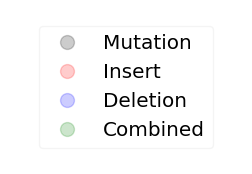

In [11]:
# First, lets take a look at the mutations that we have selected

# Plot and save the legend

legend = eBlocks_instance.plot_legend(show=True)

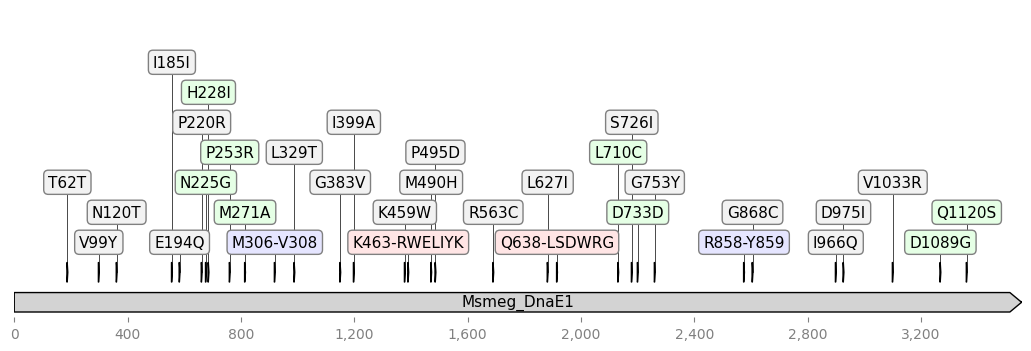

In [12]:
eBlocks_instance.plot_eblocks_mutations(idx_dna_tups=None, 
                                        eblocks=False, 
                                        mutations=True, 
                                        genename=eBlocks_instance.gene_name, 
                                        show=True,
                                        figure_length=13,
                                        figure_width=4)

In the above plots we can view the mutations and how they are divided over the gene. Now we let the program design the eBlock regions in such a way that as many mutations as possible are put on the same eBlock.

Now we are going to design the eBlocks by running the 'run' function of the class. <br>

Here, the mutations are first clustered using Kmeans clustering and optimizing the clusters based on the lowest bp in total (cost) or optimized by having as few eblocks as possible (amount). Next, the eblocks are designed and the output is stored.

In [13]:
eBlocks_instance.run()  # Set to false if you do not wish to see any plots

c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans 

Optimizing based on amount of eBlocks ...
Fewest blocks: 3 with cluster {1: [2178, 2898, 2604, 2925, 3099, 2259, 2164.5, 3313.5, 2130, 2199, 3267, 3360, 2574], 0: [360, 987, 660, 186, 297, 582, 555, 732.75, 919.5, 675, 684, 759, 813, 918, 921], 2: [1881, 1470, 1197, 1149, 1689, 1377, 1485, 1389, 1914]}
expected cost, counting 0.05 cent per bp: 1837.0 euros
Designed eBlocks and stored output in  output/


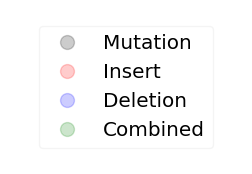

In [14]:
# Show legend

eBlocks_instance.plot_legend(show=True)

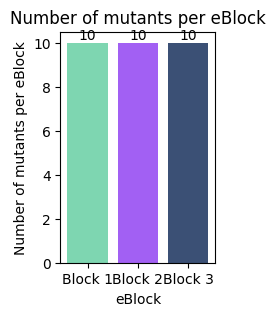

In [15]:
eBlocks_instance.make_barplot(show=True, 
                              figure_length=3, 
                              figure_width=2)

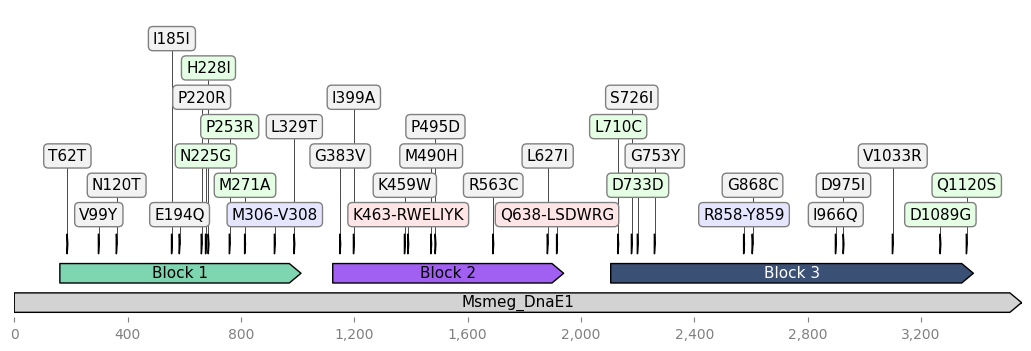

In [16]:
eBlocks_instance.plot_eblocks_mutations(idx_dna_tups=None, 
                                        eblocks=True, 
                                        mutations=True, 
                                        genename=eBlocks_instance.gene_name, 
                                        show=True, 
                                        figure_length=13, 
                                        figure_width=4)

In the first plot we can see how many mutations are on a certain eBlock. This is the number of mutations you can make using a single PCR reaction. In the second plot you can view how the eBlocks are spread over the gene and which mutations are on which eBlock. <br>

These plots are also saved in the /output directory. <br>

In this example the eBlocks are optimized, based on the amount. Let's see how this is changed if we now optimize for cost instead.

In [17]:
# Run the design of the eBlocks, now optimizing for cost

eBlocks_instance.optimization = 'cost'
eBlocks_instance.run(show=False)

c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Rosan\Anaconda3\envs\dnae\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans 

Optimizing based on price per bp ...
Lowest cost: 1263.25 with cluster {3: [2178, 1881, 1689, 2259, 2164.5, 1914, 2130, 2199], 0: [360, 660, 186, 297, 582, 555, 732.75, 675, 684, 759, 813], 2: [987, 1470, 1197, 1149, 1377, 1485, 1389, 919.5, 918, 921], 1: [2898, 2604, 2925, 3099, 3313.5, 3267, 3360, 2574]}
expected cost, counting 0.05 cent per bp: 1263.25 euros
Designed eBlocks and stored output in  output/


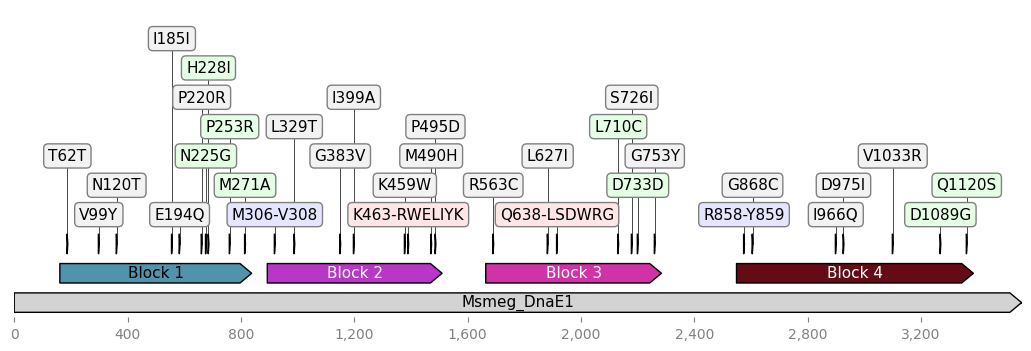

In [18]:
eBlocks_instance.plot_eblocks_mutations(idx_dna_tups=None, 
                                        eblocks=True,
                                        mutations=True, 
                                        genename=eBlocks_instance.gene_name, 
                                        show=True, 
                                        figure_length=13, 
                                        figure_width=4)

The output folder also contains a .TXT and .CSV file that contains the different mutations and eBlocks, lets take a look this

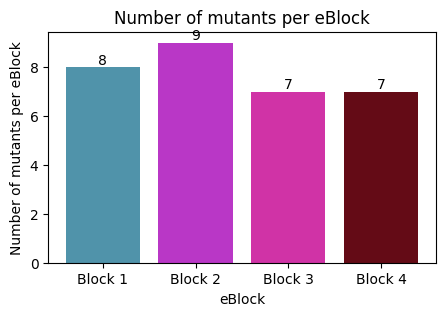

In [19]:
eBlocks_instance.make_barplot(show=True, 
                              figure_length=3, 
                              figure_width=5)

In [20]:
file = f'output/eblocks-plate-upload-template-96-{eBlocks_instance.gene_name}_N{eBlocks_instance.num_mutations}_{eBlocks_instance.optimization}.xlsx'
# TODO Why does this path not work??
file = r'C:\Users\Rosan\Documents\git\my_repositories\design_gene_blocks\tutorial\output\eblocks-plate-upload-96-Msmeg_DnaE1_N27_cost.xlsx'
df = pd.read_excel(file)

df.head(5)

,Well Position,Name,Sequence
0,A1,S726I_Block-3,tgaggccatcccgttgtggaagcggccgcaggacggggccatcatc...
1,A2,N120T_Block-1,cagcgagttctacaactccgcgaccaaggccgggatcaagccgatc...
2,A3,L329T_Block-2,cgtgtggacaccgcgcgaccggatgcccgtgtttccggtgcccgat...
3,A4,L627I_Block-3,tgaggccatcccgttgtggaagcggccgcaggacggggccatcatc...
4,A5,I966Q_Block-4,cgcatcggtcggccaagacatccgctacgggctgggcgcggtgcgc...


In this file you cans see an example plate upload. For every row, the 'Name' gives the mutation as well as the eblock number that will used.

## Other output files

Additionaly, the wt_gene_blocks.npy and mut_gene_blocks.npy files are produced that have stored the information about the eblocks and will be used for the primer generation part 

### Primer design

Now that we have our eBlocks designed, we can design primers that could open up our destination plasmid. <br>

It is important to note here that the Tm prediction here is based on Biopyhton and might be slightly different as to compared the software that you are using in the lab. So please check your primers and the Tm 

In [21]:
# Next; design IVA primers to open up destination plasmid

# TODO Check whether Kmeans is deterministic (repeat multiple times same output?)
# TODO FOR THE PRIMER DESIGN TAKE A MAX PLASMID SIZE OF 10 KB, BECAUSE THIS IS THE MAX SIZE THAT CAN BE amplified simply using PCR. Othewise throw a warning for PCR
# TODO Also design SEQ primers (count how much apart they need to be and which primers can be used to sequence which mutations)

In [27]:
# TODO Store thiss information in the class itself and create a subclass of the designeblocks for the primer design
mut_gene_blocks_fp = os.path.join(output_location, "mut_gene_blocks.npy")
wt_gene_blocks_fp = os.path.join(output_location, "wt_gene_blocks.npy")

# Create class instance for primer design

design_primers = DesignPrimers(wt_gene_blocks_fp=wt_gene_blocks_fp, 
                               mut_gene_blocks_fp=mut_gene_blocks_fp, 
                               output_location=output_location,
                               input_gene_path=msmeg_dnae1,
                               snapgene_file=vector)

TypeError: cannot unpack non-iterable NoneType object

In [30]:
# Design the primers

design_primers.run()

The overhang temperatures for Fw and Rv primer of Block_1_pos_194_1177 exceed max Tm difference of 4 degrees
The overhang temperatures for Fw and Rv primer of Block_4_pos_2861_3469 exceed max Tm difference of 4 degrees
The template temperatures for Fw and Rv primer of Block_4_pos_2861_3469 exceed max Tm difference 4 degrees
The overhang temperatures for Fw and Rv primer of Block_2_pos_1649_2260 exceed max Tm difference of 4 degrees
Complementarity between the primers for Block_1_pos_194_1177 exceeds threshold of 4
Complementarity between the primers for Block_4_pos_2861_3469 exceeds threshold of 4
Complementarity between the primers for Block_2_pos_1649_2260 exceeds threshold of 4
Primers written to file
Make sure that primer binds nowhere else in sequence


In [ ]:

# Also write results to files that SnapGene can open
primers_fp = os.path.join(output_location, "IVA_primers.csv")
gene_blocks_mutation_info_fp = os.path.join(output_location, "gene_blocks.txt")

# If you have SnapGene installed, you can add the mutations as features in this file

snapgene_output = SnapGeneOutput(wt_gene_blocks_fp = wt_gene_blocks_fp,
                                 mut_gene_blocks_fp = mut_gene_blocks_fp,
                                 primers_fp = primers_fp,
                                 output_location = output_location,
                                 snapgene_file = vector,
                                 gene_blocks_info_fp = gene_blocks_mutation_info_fp)
snapgene_output.run()

In [ ]:
# Load primers file

primers_fp = 'output/IVA_primers.csv' # TODO rename to more specific name include gene, date and number of mutations

primers = pd.read_csv(primers_fp)

In [ ]:
# TODO CLEANUP AND REMOVE UNNECCESSARY FILES
